## <a name="table">Table of Contents</a> 
1. [Pre-Process Data](#PreProcess)  


2. [Use Case A: Finding clusters of rugby players' traits current playing professional rugby ](#UseCaseA)  
    2.1 [Feature Selection](#UseCaseAFeatureSelection) <br />
    2.2 [Clusters Understanding](#UseCaseAClusterUnderstanding) <br />
    2.3 [Silhoutte Results](#UseCaseASilhoutteResults) <br />
    2.4 [Visualization of clusters for use case A](#UseCaseAVisualization)<br />
    2.5 [Experiment: Time To Load Cluster Visualizations](#UseCaseATimeExperiment)<br />
     
     
3. [Use Case B: Finding Players Attributes By Position ](#UseCaseB)  
    3.1 [Feature Selection](#UseCaseBFeatureSelection)<br />
    3.2 [Clusters Understanding](#UseCaseBClusterUnderstanding)<br />
    3.3 [Silhoutte Results](#UseCaseBSilhoutteResults)<br />
    3.4 [Visualization of clusters for use case B](#UseCaseBVisualization)<br />
    3.5 [Experiment: Time To Load Cluster Visualizations](#UseCaseBTimeExperiment)<br />

    

In [2]:
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from matplotlib.pyplot import figure
from pyclustertend import hopkins
from scipy import stats
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.tree import _tree, DecisionTreeClassifier
import io
import sys
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import folium
from folium import IFrame

## <a name="PreProcess"> 1. Pre-Processing Data</a>

In [3]:
def getClubNames(x):
    x = ast.literal_eval(x)
    str1 = " " 
    return (str1.join(x))

def getValidClubCaps(x):
    x = float(x)
    if x == 0.0 or x > 400:
        return None
    else:
        return x

def getValidHomeTownPopulation(x):
    x = float(x)
    if x == 0.0 or x > 10000000:
        return None
    else:
        return x
    

def getValidInternationalCaps(x):
    x = float(x)
    if x > 150:
        return None
    else:
        return x

def getHeight(x):
    x = float(x)
    if x > 1.5 and x < 2.2:
        return x
    else:
        return None
    
def getWeight(x):
    x = float(x)
    if x > 71000.0 and x < 150000.0:
        return x
    else:
        return None
    
def addColumnsForRugbyPositions(rugby_players_df):
    positions = ["props","hookers","locks","wing_forwards","number_8s","scrum_halves","fly_halves","centres","wingers","fullbacks"]
    dataset_column_length = len(rugby_players_df.columns)
    positionIndex = []
    for i in range(len(positions)):
        positionIndex.append((i+1,positions[i]))
    #One-Hot Encoding
    for position in positions:
        rugby_players_df["position_"+position]=rugby_players_df["Position"].map(lambda x: position == x)
    rugby_players_df.iloc[:,dataset_column_length:] = rugby_players_df.iloc[:,dataset_column_length:].astype(int)
    rugby_players_df = rugby_players_df.drop('Position', 1)
    return rugby_players_df

def edit_data_frame_with_columns(lst_of_features,rugby_players_df):
    rugby_players_df = rugby_players_df.drop('reppoints', 1)
    
    if 'birthName' not in lst_of_features:
        rugby_players_df= rugby_players_df.drop('birthName', 1)

    if 'teamnames' in lst_of_features:
        rugby_players_df["teamnames"] = rugby_players_df["teamnames"].apply(getClubNames)
    else:
        rugby_players_df= rugby_players_df.drop('teamnames', 1)
        

    if 'numClubsPlayedFor' in lst_of_features:
        rugby_players_df= rugby_players_df[pd.to_numeric(rugby_players_df['numClubsPlayedFor'], errors='coerce').notnull()]
    
    else:
        rugby_players_df= rugby_players_df.drop('numClubsPlayedFor', 1)
    
    
    if 'homePopulation' in lst_of_features:
        rugby_players_df["homePopulation"] = rugby_players_df["homePopulation"].apply(getValidHomeTownPopulation)
        rugby_players_df= rugby_players_df[pd.to_numeric(rugby_players_df['homePopulation'], errors='coerce').notnull()]
    
    else:
        rugby_players_df= rugby_players_df.drop('homePopulation', 1)
        
    if 'homeLongitude' in lst_of_features:  
        rugby_players_df= rugby_players_df[pd.to_numeric(rugby_players_df['homeLongitude'], errors='coerce').notnull()]
    else:
        rugby_players_df= rugby_players_df.drop('homeLongitude', 1)
        
    if 'homeLatitude' in lst_of_features:  
        rugby_players_df= rugby_players_df[pd.to_numeric(rugby_players_df['homeLatitude'], errors='coerce').notnull()]
    else:
        rugby_players_df= rugby_players_df.drop('homeLatitude', 1)
   

    if 'Position' in lst_of_features:  
        rugby_players_df = addColumnsForRugbyPositions(rugby_players_df)
    else:
        rugby_players_df= rugby_players_df.drop('Position', 1)
        
    
        
    if 'height'  in lst_of_features:  
        rugby_players_df["height"] = rugby_players_df["height"].apply(getHeight)
        rugby_players_df= rugby_players_df[pd.to_numeric(rugby_players_df['height'], errors='coerce').notnull()]
    else:
        rugby_players_df= rugby_players_df.drop('height', 1)
        
        
    if 'weight' in lst_of_features:  
        rugby_players_df["weight"] = rugby_players_df["weight"].apply(getWeight)
        rugby_players_df= rugby_players_df[pd.to_numeric(rugby_players_df['weight'], errors='coerce').notnull()]

    else:
        rugby_players_df= rugby_players_df.drop('weight', 1)
        
    if 'birthDate' in lst_of_features:  
        rugby_players_df= rugby_players_df[pd.to_numeric(rugby_players_df['birthDate'], errors='coerce').notnull()]
    else:
        rugby_players_df= rugby_players_df.drop('birthDate', 1)

        
    if 'clubcap'  in lst_of_features:  
        rugby_players_df["clubcap"] = rugby_players_df["clubcap"].apply(getValidClubCaps)
        rugby_players_df= rugby_players_df[pd.to_numeric(rugby_players_df['clubcap'], errors='coerce').notnull()]
    else:
        rugby_players_df= rugby_players_df.drop('clubcap', 1)
    
    if 'repcaps' in lst_of_features:  
        rugby_players_df["repcaps"] = rugby_players_df["repcaps"].apply(getValidInternationalCaps)
        rugby_players_df= rugby_players_df[pd.to_numeric(rugby_players_df['repcaps'], errors='coerce').notnull()]

    else:
        rugby_players_df= rugby_players_df.drop('repcaps', 1)
        
    return rugby_players_df

def find_largest_silhoutte_score_for_features(lst_of_features,football_teams_df):
    football_teams_df = edit_data_frame_with_columns(lst_of_features,football_teams_df)
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(football_teams_df), columns=football_teams_df.columns)
    data_scaled.head()
    distance_metric = 'euclidean'
    linkage_types = ['ward']
    max_clusters = 50
    silhoutte_scores = []
    for link in linkage_types:
        for i in range(2,max_clusters):
            cluster = AgglomerativeClustering(n_clusters=i, affinity=distance_metric, linkage=link) 
            model = cluster.fit_predict(data_scaled)
            hierarchical_clustering = pd.DataFrame(model)
            silhoutte_scores.append((link,i,silhouette_score(data_scaled,hierarchical_clustering[0],metric=distance_metric)))
            
    silhoutte_scores.sort(key=lambda x:x[2]) #Order elements by the Silhoutte Score
    return silhoutte_scores[-1]



def find_best_features(lst,num_features,football_teams_df):
    largest_element = None
    players_df = football_teams_df.copy()
    i = 0
    current_elements = []
    optimal_num_cluster = 0
    optimal_link_type = ""
    while i < num_features:
        max_shil_score = 0
        largest_element = 0
        for items in lst:
            test_players_df = players_df.copy()
            new_lst = current_elements + [items]
            link, num_clusters ,score = find_largest_silhoutte_score_for_features(new_lst,test_players_df)
            if score > max_shil_score:
                largest_element = items
                max_shil_score = score
                optimal_num_cluster = num_clusters
                optimal_link_type = link
                
        current_elements.append(largest_element)
        lst.remove(largest_element)
        i += 1
    return ((current_elements,optimal_link_type, optimal_num_cluster,max_shil_score))




In [4]:
rugby_players_df = pd.read_excel("rugby_stats_for_clubs_and_teams.xlsx", sheet_name="Sheet2_Rugby_Players")

Representing the data

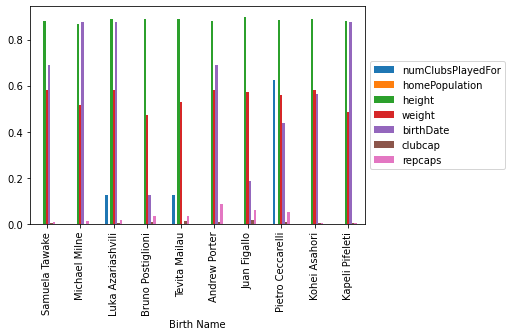

In [5]:
rugby_players_df = pd.read_excel("rugby_stats_for_clubs_and_teams.xlsx", sheet_name="Sheet2_Rugby_Players")
rugby_players_with_cateogries_df = rugby_players_df.copy()
scaler = MinMaxScaler()

player_identifiers = rugby_players_with_cateogries_df.iloc[0:10,0]

rugby_players_with_cateogries_df = rugby_players_with_cateogries_df.drop('reppoints', 1)
rugby_players_with_cateogries_df = rugby_players_with_cateogries_df.drop('birthName', 1)
rugby_players_with_cateogries_df = rugby_players_with_cateogries_df.drop('teamnames', 1)
rugby_players_with_cateogries_df = rugby_players_with_cateogries_df.drop('Position', 1)
rugby_players_with_cateogries_df = rugby_players_with_cateogries_df.drop('homeLongitude', 1)
rugby_players_with_cateogries_df = rugby_players_with_cateogries_df.drop('homeLatitude', 1)

rugbyColumns = rugby_players_with_cateogries_df.columns
rugby_players_with_cateogries_df = pd.DataFrame(scaler.fit_transform(rugby_players_with_cateogries_df))
rugby_players_with_cateogries_df.columns = rugbyColumns

rugby_players_df= rugby_players_with_cateogries_df.iloc[0:10,[0,1,2,3,4,5,6]]
                                                   
rugby_players_df["Birth Name"] = player_identifiers.values

plot1=rugby_players_df.plot.bar(x = "Birth Name")
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig = plot1.get_figure()
fig.savefig('RugbyPlayersData.png', dpi=300, bbox_inches='tight')



Boxplots of the features and data

In [4]:
#boxplot = rugby_team_weight_columns.boxplot()

## <a name="UseCaseA">2. Use Case A: Finding Players Atributes </a>

### <a name="UseCaseAFeatureSelection">2.1. FeatureSelection</a> 
[Back to Table of Contents](#table)

In [73]:
rugby_players_df = pd.read_excel("rugby_stats_for_clubs_and_teams.xlsx", sheet_name="Sheet2_Rugby_Players")
rugby_players_df.head()
print(find_best_features(['numClubsPlayedFor','homePopulation','height','weight','birthDate','clubcap','repcaps'],3,rugby_players_df))

(['birthDate', 'numClubsPlayedFor', 'homePopulation'], 'ward', 98, 0.5125896840150305)


In [8]:
rugby_players_df = pd.read_excel("rugby_stats_for_clubs_and_teams.xlsx", sheet_name="Sheet2_Rugby_Players")
rugby_players_df = edit_data_frame_with_columns(['numClubsPlayedFor', 'homePopulation', 'height'],rugby_players_df)
df1_rugby_players = rugby_players_df
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(rugby_players_df), columns=rugby_players_df.columns)
data_scaled.head()

numClubsPlayedFor  homePopulation    height
0              0.000        0.102216  0.550360
1              0.000        0.549476  0.496403
2              0.125        0.129246  0.586331
3              0.000        0.087518  0.586331
4              0.125        0.592512  0.586331

##### Identifying and removing outliers

In [9]:
data_scaled[(np.abs(stats.zscore(data_scaled)) < 3).all(axis=1)]

numClubsPlayedFor  homePopulation    height
0                0.000        0.102216  0.550360
1                0.000        0.549476  0.496403
2                0.125        0.129246  0.586331
3                0.000        0.087518  0.586331
4                0.125        0.592512  0.586331
..                 ...             ...       ...
700              0.125        0.000075  0.550360
701              0.125        0.549476  0.586331
703              0.000        0.000032  0.622302
704              0.000        0.035928  0.550360
705              0.250        0.023592  0.406475

[682 rows x 3 columns]

##### Testing to determine the clustering tendency of a data set.

In [10]:
hopkins(data_scaled,len(data_scaled))

0.08109038575295453

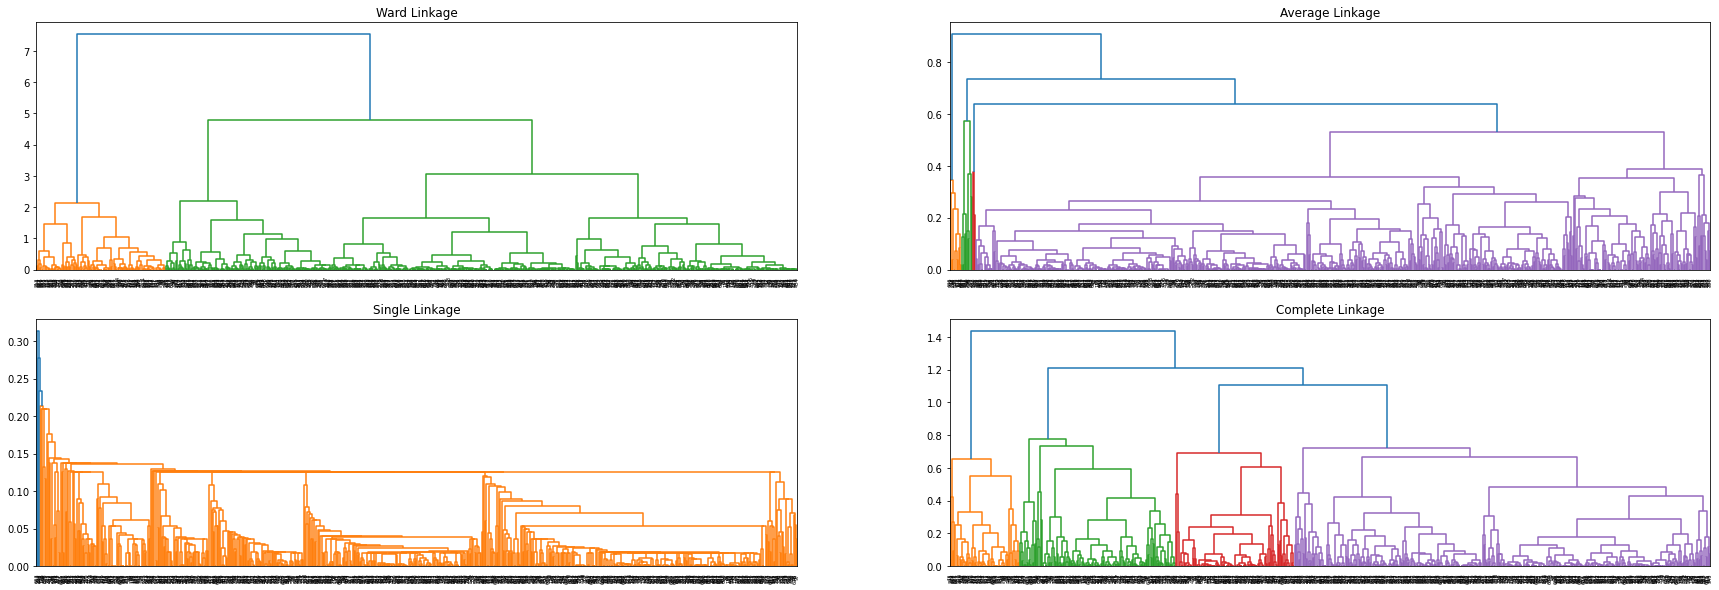

In [11]:
import scipy.cluster.hierarchy as shc
rows = 2
columns = 2
figure = plt.figure(figsize=(30, 10))  
figure.add_subplot(rows, columns, 1)
plt.title("Ward Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='ward'))
figure.add_subplot(rows, columns, 2)
plt.title("Average Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='average'))
figure.add_subplot(rows, columns, 3)
plt.title("Single Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='single'))
figure.add_subplot(rows, columns, 4)
plt.title("Complete Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='complete'))
figure.savefig('DendogramsRugbyPlayersA1.png', dpi=300, bbox_inches='tight')


## Applying Hierarchical clustering for the clusters

In [12]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
team_models = cluster.fit_predict(data_scaled)

### <a name="UseCaseAClusterUnderstanding">2.2 Feature Selection and Understanding Clusters</a> 
[Back to Table of Contents](#table)

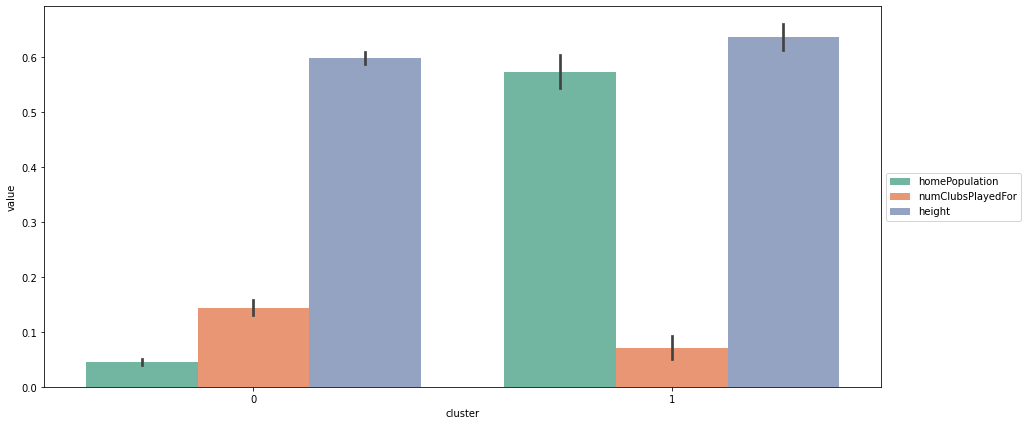

In [13]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
minMaxscaler = MinMaxScaler()
scaledDataFrame = pd.DataFrame(minMaxscaler.fit_transform(df1_rugby_players))
scaledDataFrame.columns = df1_rugby_players.columns
scaledDataFrame['cluster'] = cluster.labels_
meansDataFrame = scaledDataFrame.groupby('cluster').mean().reset_index()
variablesDeviations = pd.DataFrame(columns=['Vars', 'Deviation'])
i = 0
while i < len(meansDataFrame.columns[1:]):
    variablesDeviations.loc[len(variablesDeviations), :] = [meansDataFrame.columns[1:][i], np.std(meansDataFrame[meansDataFrame.columns[1:][i]])]
    i+=1
    
includedColumns = list(variablesDeviations.sort_values('Deviation', ascending=False).head(4).Vars.values) + ['cluster']
finalData = scaledDataFrame[includedColumns].melt(id_vars='cluster')
figure, axix = plt.subplots(figsize=(15, 7))
sns.barplot(x='cluster', y='value', hue='variable', data=finalData, palette='Set2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("clustersFromRugbyPlayersA.jpg", dpi=300)

706
706


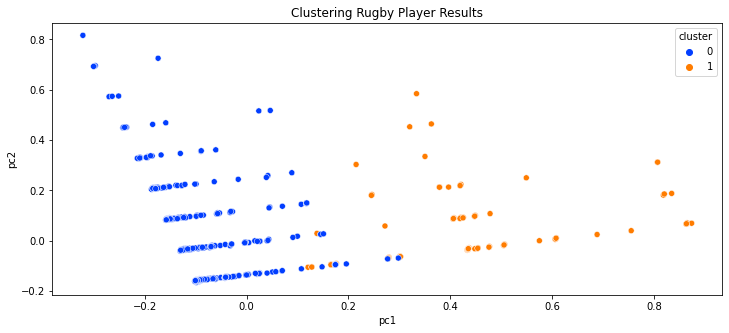

In [14]:
from sklearn.decomposition import PCA
fig, (sub1) = plt.subplots(1, figsize=(12, 5))
pca_vehicle_data = PCA(n_components=2)
print(len(data_scaled))
principalComponents_vehicles = pca_vehicle_data.fit_transform(data_scaled)
print(len(principalComponents_vehicles))
sns.scatterplot(x=principalComponents_vehicles[:,0], y=principalComponents_vehicles[:,1], hue=team_models, palette='bright',ax=sub1);
sub1.set(xlabel="pc1", ylabel="pc2", title="Clustering Rugby Player Results")
sub1.legend(title='cluster');
fig.savefig('PCARugbyPlayersA1.png', dpi=300, bbox_inches='tight')

### <a name="UseCaseASilhoutteResults">2.3 Analysing Cluster Results with Different linkage criteria and number of clusters</a> 
[Back to Table of Contents](#table)

#### Comparing the different linkage criteria using Silhoute Score

In [15]:
sil_scores = []
dav_scores = []
calin_scores = []
n_clusters = []

for i in range(2,20):
    cluster1 = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    team_models1 = cluster1.fit_predict(data_scaled)
    hierarchical_clustering = pd.DataFrame(team_models1)
    dav_scores.append(davies_bouldin_score(data_scaled,hierarchical_clustering[0]))
    sil_scores.append(silhouette_score(data_scaled,hierarchical_clustering[0],metric='euclidean'))
    calin_scores.append(calinski_harabasz_score(data_scaled,hierarchical_clustering[0]))
    n_clusters.append(i)
    
hierarchicial_clustering_results_df = {'Num Clusters': n_clusters,'Silhouette Score': sil_scores, 'Davies Bouldin Score': dav_scores,'Calinski Harabasz Score': calin_scores}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  Num Clusters &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0  &             2 &          0.518689 &              0.784793 &               519.206079 \\
1  &             3 &          0.397693 &              0.936691 &               517.623429 \\
2  &             4 &          0.306517 &              0.982247 &               466.881019 \\
3  &             5 &          0.309204 &              0.985786 &               413.040917 \\
4  &             6 &          0.293466 &              1.147322 &               390.150328 \\
5  &             7 &          0.298676 &              1.099550 &               362.882044 \\
6  &             8 &          0.285052 &              1.104121 &               347.941794 \\
7  &             9 &          0.258411 &              1.136668 &               343.009793 \\
8  &            10 &          0.270362 &              1.125589 &               342.896870 \\
9  &            11 &         

In [16]:
cluster1 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
team_models1 = cluster1.fit_predict(data_scaled)
hierarchical_clustering1 = pd.DataFrame(team_models1)
davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering1[0])
silhouette_score1 = silhouette_score(data_scaled,hierarchical_clustering1[0],metric='euclidean')
calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering1[0])


cluster2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')  
team_models2 = cluster2.fit_predict(data_scaled)
hierarchical_clustering2 = pd.DataFrame(team_models2)
davies_bouldin_score2 = davies_bouldin_score(data_scaled,hierarchical_clustering2[0])
silhouette_score2 = silhouette_score(data_scaled,hierarchical_clustering2[0],metric='euclidean')
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,hierarchical_clustering2[0])

cluster3 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')  
team_models3 = cluster3.fit_predict(data_scaled)
hierarchical_clustering3 = pd.DataFrame(team_models3)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,hierarchical_clustering3[0])
silhouette_score3 = silhouette_score(data_scaled,hierarchical_clustering3[0],metric='euclidean')
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,hierarchical_clustering3[0])

cluster4 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single') 
team_models4 = cluster4.fit_predict(data_scaled)
hierarchical_clustering4 = pd.DataFrame(team_models4)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,hierarchical_clustering4[0])
silhouette_score4 = silhouette_score(data_scaled,hierarchical_clustering4[0],metric='euclidean')
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,hierarchical_clustering4[0])

hierarchicial_clustering_results_df = {'Linkage Type': ['Ward','Average','Complete','Single'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())

\begin{tabular}{llrrr}
\toprule
{} & Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &         Ward &          0.518689 &              0.784793 &               519.206079 \\
1 &      Average &          0.561221 &              0.452825 &                97.335089 \\
2 &     Complete &          0.497704 &              0.681569 &               321.761594 \\
3 &       Single &          0.469702 &              0.403869 &                 4.611696 \\
\bottomrule
\end{tabular}



#### Determining the number of clusters for K-means Algorithm using Silhouette Visualizer

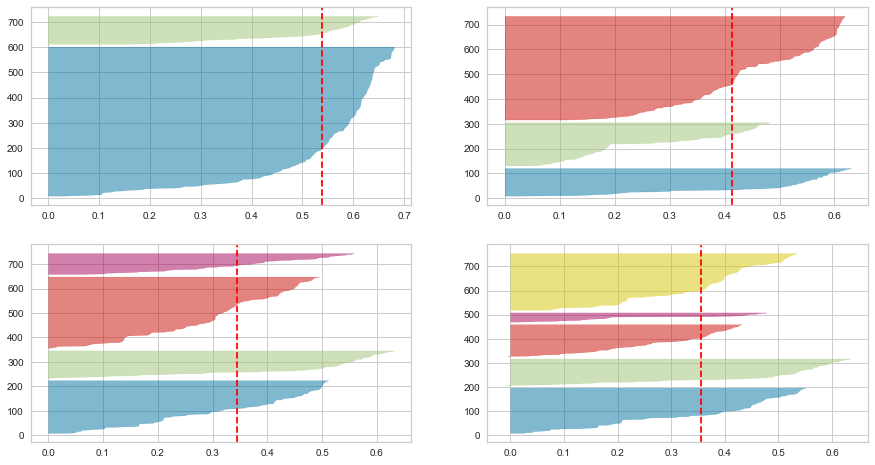

In [17]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled)

#### Criteria for DBSCAN

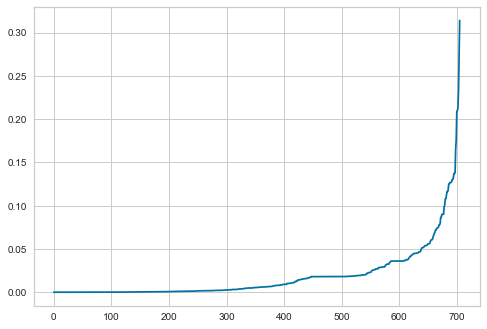

In [18]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#### Comparing the cell types

In [19]:
#Hierarchical clustering, K-means clustering with cosine k-means, .....
kmeans_norm = KMeans(n_clusters=2).fit(data_scaled)
#test_sample = data_scaled.shape[1]+1 
dbs_data = DBSCAN(eps=0.21, min_samples=2).fit(data_scaled)
#print("dbs_data.labels_ is:",dbs_data.labels_)

silhouette_score1 = silhouette_score(data_scaled, hierarchical_clustering1[0],metric='euclidean')
silhouette_score2 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='euclidean')
silhouette_score3 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='cosine')
silhouette_score4 = silhouette_score(data_scaled, dbs_data.labels_)

davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering1[0])
davies_bouldin_score2 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,dbs_data.labels_)

calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering1[0])
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,dbs_data.labels_)

clustering_results_df = {'Linkage Type': ['Agglomerative Hierarchical clustering(linkage = Average)','Kmeans','Cosine Based Kmeans','DBSCAN'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_of_results = pd.DataFrame(clustering_results_df)  
print(df_of_results.to_latex())





\begin{tabular}{llrrr}
\toprule
{} &                                       Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &  Agglomerative Hierarchical clustering(linkage ... &          0.518689 &              0.784793 &               519.206079 \\
1 &                                             Kmeans &          0.538999 &              0.736122 &               543.998169 \\
2 &                                Cosine Based Kmeans &          0.711246 &              0.736122 &               543.998169 \\
3 &                                             DBSCAN &          0.521173 &              1.612346 &                11.358514 \\
\bottomrule
\end{tabular}



### Table of rules

In [20]:
dct_of_clusters = {"cluster numbers":[1,2],"cluster descriptions": ["homePopulation <= 3143476.0","homePopulation > 3143476.0"]
}


df_of_results = pd.DataFrame(dct_of_clusters)  
print(df_of_results.to_latex())


\begin{tabular}{lrl}
\toprule
{} &  cluster numbers &         cluster descriptions \\
\midrule
0 &                1 &  homePopulation <= 3143476.0 \\
1 &                2 &   homePopulation > 3143476.0 \\
\bottomrule
\end{tabular}




### <a name="UseCaseAVisualization">2.4 Visualization of clusters for use case A</a> 
[Back to Table of Contents](#table)

In [6]:
import io
import sys
import folium
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWebEngineWidgets import QWebEngineView 
from PyQt5.QtWebEngineWidgets import QWebEngineSettings as QWebSettings
from folium import IFrame
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import collections, numpy
from matplotlib import animation
from pyclustertend import hopkins
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import folium

class Window(QtWidgets.QMainWindow):
    def __init__(self,dataset):
        self._dataset = dataset
        self._df_including_cordinates = self._dataset.copy()
        self._dataset.drop('birthName', inplace=True, axis=1)
        self._dataset.drop('teamnames', inplace=True, axis=1)
        self._dataset.drop('homeLongitude', inplace=True, axis=1)
        self._dataset.drop('homeLatitude', inplace=True, axis=1)
        super().__init__()
        self.initWindow()

    def initWindow(self):
        self.setWindowTitle(self.tr("Rugby Players Clusters Based on Hometown"))
        self.setFixedSize(1500, 800)
        self.editField1 = QtWidgets.QLineEdit(self)
        self.editField2 = QtWidgets.QLineEdit(self)
        self.editField3 = QtWidgets.QLineEdit(self)
        self.label5 = QtWidgets.QLabel('red',self)
        self.label5.setHidden(True)
        self.m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
        self.buttonUI()

    def buttonUI(self):
        submitButton = QtWidgets.QPushButton(self.tr("Submit"))
        submitButton.clicked.connect(self.calculateClusterPressed)
        self.editField1.setFixedSize(120, 50)
        self.editField2.setFixedSize(120, 50)
        self.editField3.setFixedSize(120, 50)
        submitButton.move(20, 260)
        label1 = QtWidgets.QLabel(self)
        label1.setText("Num Clubs Played For:")
        label1.setFixedSize(120, 50)
        label2 = QtWidgets.QLabel(self)
        label2.setText("Home Population:")
        label2.setFixedSize(120, 50)
        label3 = QtWidgets.QLabel(self)
        label3.setText("Height:")
        label3.setFixedSize(120, 50)
        self.label5.setText("Data is an outlier")
        self.label5.setFixedSize(120, 50)
        self.label5.setStyleSheet("background-color: red")
        self.view = QWebEngineView()
        self.view.setContentsMargins(50, 50, 50, 50)
        central_widget = QtWidgets.QWidget()
        self.setCentralWidget(central_widget)
        lay = QtWidgets.QHBoxLayout(central_widget)
        button_container = QtWidgets.QWidget()
        vlay = QtWidgets.QVBoxLayout(button_container)
        vlay.setSpacing(20)
        vlay.addStretch()
        vlay.addWidget(label1)
        vlay.addWidget(self.editField1)
        vlay.addWidget(label2)
        vlay.addWidget(self.editField2)
        vlay.addWidget(label3)
        vlay.addWidget(self.editField3)
        vlay.addWidget(submitButton)
        vlay.addWidget(self.label5)
        vlay.addStretch()
        lay.addWidget(button_container)
        lay.addWidget(self.view, stretch=1)
        data = io.BytesIO()
        self.m.save(data, close_file=False)
        self.view.setHtml(data.getvalue().decode())
    
    def calculateClusterPressed(self):
        insertData = {'numClubsPlayedFor':self.editField1.text(),
                       'homePopulation':self.editField2.text(), 'height':self.editField3.text() }
        self._dataset = self._dataset.append(insertData, ignore_index=True)
        scaler = MinMaxScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(self._dataset), columns=self._dataset.columns)
        cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
        team_models = cluster.fit_predict(data_scaled)
        hierarchical_clustering = pd.DataFrame(team_models)
        dct_of_colour =  {0:"red", 1:"green"}
        new_item_cluster = team_models[-1]
        if np.count_nonzero(team_models == new_item_cluster) == 1:
            self.label5.setHidden(False)
        else:
            self.label5.setHidden(True)
            i = 0
            for index, row in self._df_including_cordinates.iterrows():
                if hierarchical_clustering[0][i] == team_models[-1]:
                    html="""
                    <h1>""" + str(row['birthName']) + """'s data</h1><br>
                    <b> Name: </b> """ + str(row['birthName']) + """ <br>
                    <b> Club Names: </b> """ + str(row['teamnames']) + """ <br>
                    <b> Height: </b> """ + str(row['height']) + """ <br>
                    <b> Hometown's population: </b> """ + str(row['homePopulation']) + """ <br>
                    <b> Num Clubs Played For: </b> """ + str(row['numClubsPlayedFor']) + """ <br>
                    """
                    frame = IFrame(html=html, width=500, height=300)
                    pop_text = folium.Popup(frame, max_width=2650)
                    folium.Marker(
                    [row['homeLatitude'], row['homeLongitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(self.m)
                i += 1
                self.m
                data = io.BytesIO()
                self.m.save(data, close_file=False)
                self.view.setHtml(data.getvalue().decode())
        
        
if __name__ == "__main__":
    rugby_players_df = pd.read_excel("rugby_stats_for_clubs_and_teams.xlsx", sheet_name="Sheet2_Rugby_Players")
    df1_rugby_players = edit_data_frame_with_columns(['birthName','teamnames','homeLongitude','homeLatitude','numClubsPlayedFor', 'homePopulation', 'height'],rugby_players_df)
    App = QtCore.QCoreApplication.instance()
    if App is None:
        App = QtWidgets.QApplication(sys.argv)
    window = Window(df1_rugby_players)
    window.show()
    sys.exit(App.exec())



SystemExit: 0

/Users/colmclery/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



### <a name="UseCaseATimeExperiment">2.5 Experimenting Time To Load Cluster items</a> 
[Back to Table of Contents](#table)

In [21]:
import time
num_clusters = 2
affin = 'euclidean'
link = 'ward'
rugby_players_df = pd.read_excel("rugby_stats_for_clubs_and_teams.xlsx", sheet_name="Sheet2_Rugby_Players")
df1_rugby_players = edit_data_frame_with_columns(['birthName','teamnames','homeLongitude','homeLatitude','numClubsPlayedFor', 'homePopulation', 'height'],rugby_players_df)
df1_rugby_players_copy = df1_rugby_players.copy()
df1_rugby_players.drop('birthName', inplace=True, axis=1)
df1_rugby_players.drop('teamnames', inplace=True, axis=1)
df1_rugby_players.drop('homeLongitude', inplace=True, axis=1)
df1_rugby_players.drop('homeLatitude', inplace=True, axis=1)
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df1_rugby_players), columns=df1_rugby_players.columns)
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity=affin, linkage=link) 
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
data_scaled.insert((data_scaled.shape[1]),'agglomerative',hierarchical_clustering)
dct_of_colour =  {0:"red", 1:"green"}
times_dct = {"Cluster ID":[],"Number Of Players":[],"Time To Load":[],}
m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
cluster_id = 0
for cluster in range(num_clusters):
    i = 0
    t1 = time.time()
    count_per_cluster = 0
    for index, row in df1_rugby_players_copy.iterrows():                       
        if team_models[i] == cluster_id:
            count_per_cluster += 1
            html="""
                    <h1>""" + str(row['birthName']) + """'s data</h1><br>
                    <p>
                    </p>
                    <b> Name: </b> """ + str(row['birthName']) + """ <br>
                    <b> Club Names: </b> """ + str(row['teamnames']) + """ <br>
                    <b> Height: </b> """ + str(row['height']) + """ <br>
                    <b> Hometown's population: </b> """ + str(row['homePopulation']) + """ <br>
                    <b> Num Clubs Played For: </b> """ + str(row['numClubsPlayedFor']) + """ <br>
                    """

            frame = IFrame(html=html, width=500, height=300)
            pop_text = folium.Popup(frame, max_width=2650)
            folium.Marker(
                    [row['homeLatitude'], row['homeLongitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(m)
        i += 1
    

    t2 = time.time()
    times_dct["Time To Load"].append(t2 - t1)
    cluster_id+=1
    times_dct["Number Of Players"].append(count_per_cluster)
    times_dct["Cluster ID"].append(cluster_id)
df = pd.DataFrame(times_dct)
print(df.to_latex())
data = io.BytesIO()
m.save(data, close_file=False)
m





\begin{tabular}{lrrr}
\toprule
{} &  Cluster ID &  Number Of Players &  Time To Load \\
\midrule
0 &           1 &                586 &      0.485487 \\
1 &           2 &                120 &      0.167766 \\
\bottomrule
\end{tabular}



## <a name="UseCaseB">3. Use Case A: Finding Players Attributes By Position </a>

### <a name="UseCaseBFeatureSelection">3.1. FeatureSelection</a> 
[Back to Table of Contents](#table)

In [22]:
rugby_players_df = pd.read_excel("rugby_stats_for_clubs_and_teams.xlsx", sheet_name="Sheet2_Rugby_Players")
rugby_players_df.head()
print(find_best_features(['numClubsPlayedFor','Position','homePopulation','height','weight','birthDate','clubcap','repcaps'],3,rugby_players_df))

(['Position', 'numClubsPlayedFor', 'height'], 'ward', 10, 0.8461555284997264)


In [23]:
rugby_players_df = pd.read_excel("rugby_stats_for_clubs_and_teams.xlsx", sheet_name="Sheet2_Rugby_Players")
rugby_players_df = edit_data_frame_with_columns(['Position', 'height', 'weight'],rugby_players_df)
df1_rugby_players = rugby_players_df
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(rugby_players_df), columns=rugby_players_df.columns)
data_scaled.head()

height    weight  position_props  position_hookers  position_locks  \
0  0.550360  0.695652             1.0               0.0             0.0   
1  0.496403  0.608696             1.0               0.0             0.0   
2  0.586331  0.695652             1.0               0.0             0.0   
3  0.586331  0.550725             1.0               0.0             0.0   
4  0.586331  0.623188             1.0               0.0             0.0   

   position_wing_forwards  position_number_8s  position_scrum_halves  \
0                     0.0                 0.0                    0.0   
1                     0.0                 0.0                    0.0   
2                     0.0                 0.0                    0.0   
3                     0.0                 0.0                    0.0   
4                     0.0                 0.0                    0.0   

   position_fly_halves  position_centres  position_wingers  position_fullbacks  
0                  0.0               0.0               0.0                 0.0  
1                  0.0               0.0               0.0                 0.0  
2                  0.0               0.0               0.0                 0.0  
3                  0.0               0.0               0.0                 0.0  
4                  0.0               0.0               0.0                 0.0

##### Identifying and removing outliers

In [24]:
data_scaled[(np.abs(stats.zscore(data_scaled)) < 3).all(axis=1)]

height    weight  position_props  position_hookers  position_locks  \
0    0.550360  0.695652             1.0               0.0             0.0   
1    0.496403  0.608696             1.0               0.0             0.0   
2    0.586331  0.695652             1.0               0.0             0.0   
3    0.586331  0.550725             1.0               0.0             0.0   
4    0.586331  0.623188             1.0               0.0             0.0   
..        ...       ...             ...               ...             ...   
844  0.460432  0.159420             0.0               0.0             0.0   
845  0.604317  0.347826             0.0               0.0             0.0   
846  0.514388  0.260870             0.0               0.0             0.0   
847  0.730216  0.376812             0.0               0.0             0.0   
848  0.496403  0.260870             0.0               0.0             0.0   

     position_wing_forwards  position_number_8s  position_scrum_halves  \
0                       0.0                 0.0                    0.0   
1                       0.0                 0.0                    0.0   
2                       0.0                 0.0                    0.0   
3                       0.0                 0.0                    0.0   
4                       0.0                 0.0                    0.0   
..                      ...                 ...                    ...   
844                     0.0                 0.0                    0.0   
845                     0.0                 0.0                    0.0   
846                     0.0                 0.0                    0.0   
847                     0.0                 0.0                    0.0   
848                     0.0                 0.0                    0.0   

     position_fly_halves  position_centres  position_wingers  \
0                    0.0               0.0               0.0   
1                    0.0               0.0               0.0   
2                    0.0               0.0               0.0   
3                    0.0               0.0               0.0   
4                    0.0               0.0               0.0   
..                   ...               ...               ...   
844                  0.0               0.0               1.0   
845                  0.0               0.0               1.0   
846                  0.0               0.0               1.0   
847                  0.0               0.0               1.0   
848                  0.0               0.0               1.0   

     position_fullbacks  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
..                  ...  
844                 0.0  
845                 0.0  
846                 0.0  
847                 0.0  
848                 0.0  

[634 rows x 12 columns]

##### Testing to determine the clustering tendency of a data set.

In [25]:
hopkins(data_scaled,len(data_scaled))

0.012688014387854427

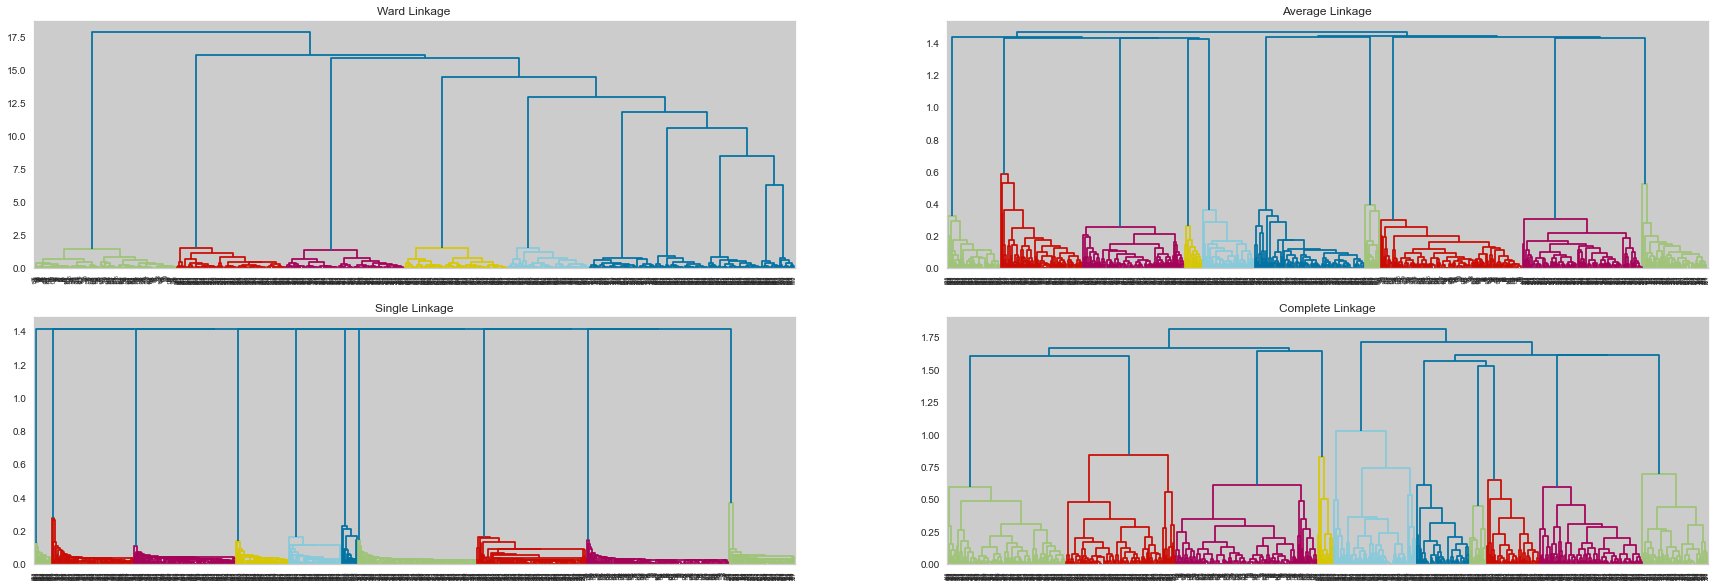

In [26]:
import scipy.cluster.hierarchy as shc
rows = 2
columns = 2
figure = plt.figure(figsize=(30, 10))  
figure.add_subplot(rows, columns, 1)
plt.title("Ward Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='ward'))
figure.add_subplot(rows, columns, 2)
plt.title("Average Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='average'))
figure.add_subplot(rows, columns, 3)
plt.title("Single Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='single'))
figure.add_subplot(rows, columns, 4)
plt.title("Complete Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='complete'))
figure.savefig('DendogramsRugbyPlayersB1.png', dpi=300, bbox_inches='tight')

## Applying Hierarchical clustering for the clusters

In [27]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=13, affinity='euclidean', linkage='ward')  
team_models = cluster.fit_predict(data_scaled)


### <a name="UseCaseBClusterUnderstanding">3.2 Feature Selection and Understanding Clusters</a> 
[Back to Table of Contents](#table)

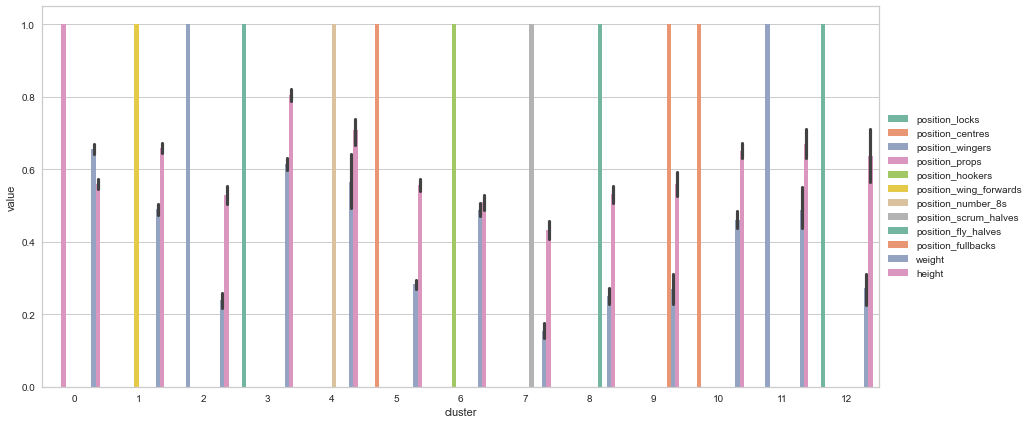

In [28]:
cluster = AgglomerativeClustering(n_clusters=13, affinity='euclidean', linkage='ward')  
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
minMaxscaler = MinMaxScaler()
scaledDataFrame = pd.DataFrame(minMaxscaler.fit_transform(df1_rugby_players))
scaledDataFrame.columns = df1_rugby_players.columns
scaledDataFrame['cluster'] = cluster.labels_
meansDataFrame = scaledDataFrame.groupby('cluster').mean().reset_index()
variablesDeviations = pd.DataFrame(columns=['Vars', 'Deviation'])
i = 0
while i < len(meansDataFrame.columns[1:]):
    variablesDeviations.loc[len(variablesDeviations), :] = [meansDataFrame.columns[1:][i], np.std(meansDataFrame[meansDataFrame.columns[1:][i]])]
    i+=1
includedColumns = list(variablesDeviations.sort_values('Deviation', ascending=False).head(20).Vars.values) + ['cluster']
finalData = scaledDataFrame[includedColumns].melt(id_vars='cluster')
figure, axix = plt.subplots(figsize=(15, 7))
sns.barplot(x='cluster', y='value', hue='variable', data=finalData, palette='Set2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("clustersFromRugbyPlayersB.jpg", dpi=300)

### <a name="UseCaseBSilhoutteResults">3.3 Analysing Cluster Results with Different linkage criteria and number of clusters</a> 
[Back to Table of Contents](#table)

#### Comparing the different linkage criteria using Silhoute Score

In [29]:
sil_scores = []
dav_scores = []
calin_scores = []
n_clusters = []

for i in range(2,60):
    cluster1 = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    team_models1 = cluster1.fit_predict(data_scaled)
    hierarchical_clustering = pd.DataFrame(team_models1)
    dav_scores.append(davies_bouldin_score(data_scaled,hierarchical_clustering[0]))
    sil_scores.append(silhouette_score(data_scaled,hierarchical_clustering[0],metric='euclidean'))
    calin_scores.append(calinski_harabasz_score(data_scaled,hierarchical_clustering[0]))
    n_clusters.append(i)
    
hierarchicial_clustering_results_df = {'Num Clusters': n_clusters,'Silhouette Score': sil_scores, 'Davies Bouldin Score': dav_scores,'Calinski Harabasz Score': calin_scores}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  Num Clusters &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0  &             2 &          0.271956 &              0.963689 &               214.817946 \\
1  &             3 &          0.395332 &              0.934241 &               243.770182 \\
2  &             4 &          0.516116 &              0.916904 &               310.471476 \\
3  &             5 &          0.618101 &              0.906155 &               398.840737 \\
4  &             6 &          0.701149 &              0.884256 &               526.461165 \\
5  &             7 &          0.772177 &              0.811588 &               754.815396 \\
6  &             8 &          0.828685 &              0.679250 &              1241.951467 \\
7  &             9 &          0.864834 &              0.687837 &              2245.101954 \\
8  &            10 &          0.885025 &              0.177165 &              4476.832030 \\
9  &            11 &         

In [30]:
cluster1 = AgglomerativeClustering(n_clusters=13, affinity='euclidean', linkage='ward')  
team_models1 = cluster1.fit_predict(data_scaled)
hierarchical_clustering1 = pd.DataFrame(team_models1)
davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering1[0])
silhouette_score1 = silhouette_score(data_scaled,hierarchical_clustering1[0],metric='euclidean')
calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering1[0])


cluster2 = AgglomerativeClustering(n_clusters=13, affinity='euclidean', linkage='average')  
team_models2 = cluster2.fit_predict(data_scaled)
hierarchical_clustering2 = pd.DataFrame(team_models2)
davies_bouldin_score2 = davies_bouldin_score(data_scaled,hierarchical_clustering2[0])
silhouette_score2 = silhouette_score(data_scaled,hierarchical_clustering2[0],metric='euclidean')
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,hierarchical_clustering2[0])

cluster3 = AgglomerativeClustering(n_clusters=13, affinity='euclidean', linkage='complete')  
team_models3 = cluster3.fit_predict(data_scaled)
hierarchical_clustering3 = pd.DataFrame(team_models3)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,hierarchical_clustering3[0])
silhouette_score3 = silhouette_score(data_scaled,hierarchical_clustering3[0],metric='euclidean')
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,hierarchical_clustering3[0])

cluster4 = AgglomerativeClustering(n_clusters=13, affinity='euclidean', linkage='single') 
team_models4 = cluster4.fit_predict(data_scaled)
hierarchical_clustering4 = pd.DataFrame(team_models4)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,hierarchical_clustering4[0])
silhouette_score4 = silhouette_score(data_scaled,hierarchical_clustering4[0],metric='euclidean')
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,hierarchical_clustering4[0])

hierarchicial_clustering_results_df = {'Linkage Type': ['Ward','Average','Complete','Single'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{llrrr}
\toprule
{} & Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &         Ward &          0.738316 &              0.443084 &              4195.121437 \\
1 &      Average &          0.838128 &              0.250815 &              3583.228376 \\
2 &     Complete &          0.790744 &              0.457212 &              3952.701587 \\
3 &       Single &          0.841149 &              0.184161 &              3555.852886 \\
\bottomrule
\end{tabular}



#### Determining the number of clusters for K-means Algorithm using Silhouette Visualizer

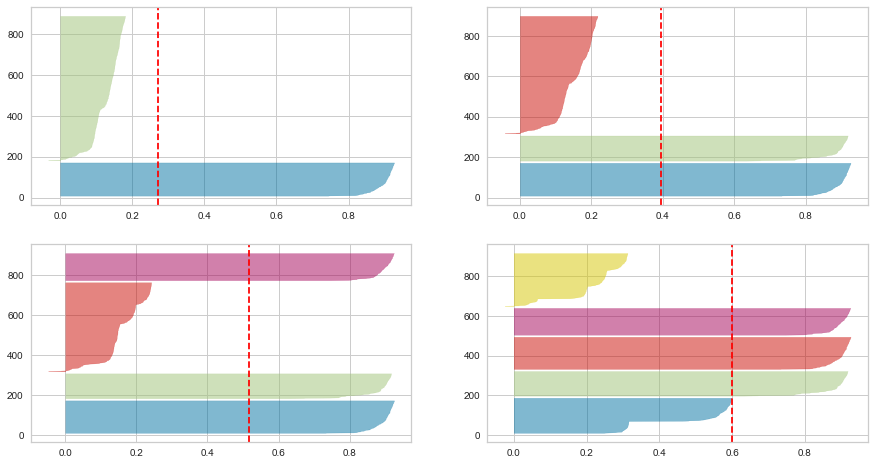

In [31]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled)

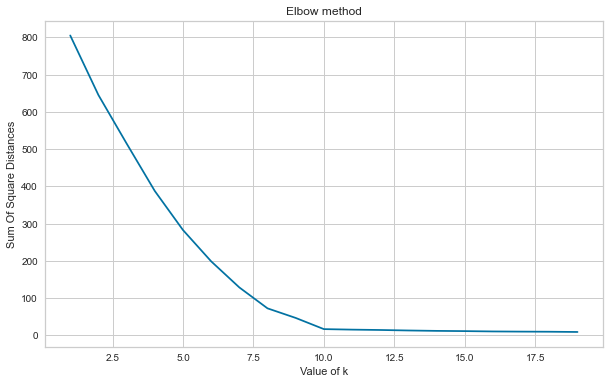

In [32]:
#Using Elbow Method when num clusters > 5
sum_of_squared_distances = []
cluster_range = range(1,20)
for cluster_num in cluster_range:
    kModel = KMeans(n_clusters=cluster_num)
    kModel.fit(data_scaled)
    sum_of_squared_distances.append(kModel.inertia_)
plt.figure(figsize=(10,6))
plt.plot(cluster_range, sum_of_squared_distances, 'bx-')
plt.xlabel('Value of k')
plt.ylabel('Sum Of Square Distances')
plt.title('Elbow method')
plt.show()

#### Criteria for DBSCAN

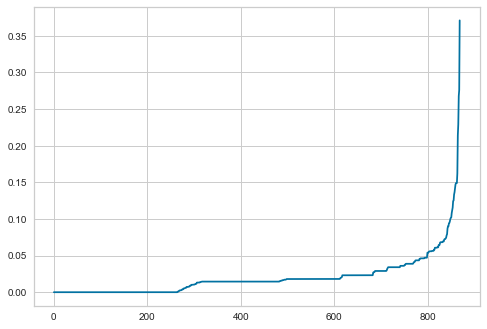

In [33]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#### Comparing the cell types

In [34]:
kmeans_norm = KMeans(n_clusters=10).fit(data_scaled)
dbs_data = DBSCAN(eps=0.38, min_samples=2).fit(data_scaled)

silhouette_score1 = silhouette_score(data_scaled, hierarchical_clustering1[0],metric='euclidean')
silhouette_score2 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='euclidean')
silhouette_score3 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='cosine')
silhouette_score4 = silhouette_score(data_scaled, dbs_data.labels_)

davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering1[0])
davies_bouldin_score2 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,dbs_data.labels_)

calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering1[0])
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,dbs_data.labels_)

clustering_results_df = {'Linkage Type': ['Agglomerative Hierarchical clustering(linkage = Average)','Kmeans','Cosine Based Kmeans','DBSCAN'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_of_results = pd.DataFrame(clustering_results_df)  
print(df_of_results.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &                                       Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &  Agglomerative Hierarchical clustering(linkage ... &          0.738316 &              0.443084 &              4195.121437 \\
1 &                                             Kmeans &          0.885025 &              0.177165 &              4476.832030 \\
2 &                                Cosine Based Kmeans &          0.984249 &              0.177165 &              4476.832030 \\
3 &                                             DBSCAN &          0.885025 &              0.177165 &              4476.832030 \\
\bottomrule
\end{tabular}



#### Gather cluster rules

In [35]:
dct_of_clusters = {"cluster numbers":[1,2,3,4,5,6,7,8,9,10,11,12,13],"cluster descriptions": ["Players that play as props",
 "Players that play as wing-forwards",
 "Players that play as wingers who are smaller and light",
 "Players that play as locks","Players that play as number 8s",
 "Players that play as centres that are short and light",
 "Players that play as hookers",
 "Players that play as scrum-halves",
 "Players that play as fly-halves that are short", 
 "Players that play as full-backs",  
 "Players that play as centres that are heavy and tall", 
 "Players that play as wingers that are heavy and tall", 
 "Players that play as fly-halves that are tall"]
}

df_of_results = pd.DataFrame(dct_of_clusters)  
print(df_of_results.to_latex())

\begin{tabular}{lrl}
\toprule
{} &  cluster numbers &                               cluster descriptions \\
\midrule
0  &                1 &                         Players that play as props \\
1  &                2 &                 Players that play as wing-forwards \\
2  &                3 &  Players that play as wingers who are smaller a... \\
3  &                4 &                         Players that play as locks \\
4  &                5 &                     Players that play as number 8s \\
5  &                6 &  Players that play as centres that are short an... \\
6  &                7 &                       Players that play as hookers \\
7  &                8 &                  Players that play as scrum-halves \\
8  &                9 &     Players that play as fly-halves that are short \\
9  &               10 &                    Players that play as full-backs \\
10 &               11 &  Players that play as centres that are heavy an... \\
11 &               12 &  


### <a name="UseCaseBVisualization">3.4 Visualization of clusters for use case B</a> 
[Back to Table of Contents](#table)

In [7]:
import io
import sys
import folium
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWebEngineWidgets import QWebEngineView 
from PyQt5.QtWebEngineWidgets import QWebEngineSettings as QWebSettings
from folium import IFrame
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import collections, numpy
from matplotlib import animation
from pyclustertend import hopkins
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import folium

class Window(QtWidgets.QMainWindow):
    def __init__(self,dataset):
        self._dataset = dataset
        self._df_including_cordinates = self._dataset.copy()
        self._dataset.drop('birthName', inplace=True, axis=1)
        self._dataset.drop('teamnames', inplace=True, axis=1)
        self._dataset.drop('homeLongitude', inplace=True, axis=1)
        self._dataset.drop('homeLatitude', inplace=True, axis=1)
        super().__init__()
        self.initWindow()

    def initWindow(self):
        self.setWindowTitle(self.tr("Rugby Players Clusters Based On Position and Size Of Players"))
        self.setFixedSize(1500, 800)
        self.comboBox1 = QtWidgets.QComboBox(self)
        self.editField2 = QtWidgets.QLineEdit(self)
        self.editField3 = QtWidgets.QLineEdit(self)
        self.label5 = QtWidgets.QLabel('red',self)
        self.label5.setHidden(True)
        self.m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
        self.buttonUI()

    def buttonUI(self):
        submitButton = QtWidgets.QPushButton(self.tr("Submit"))
        submitButton.clicked.connect(self.calculateClusterPressed)
        self.comboBox1.setFixedSize(120, 50)
        self.comboBox1.addItem("prop")
        self.comboBox1.addItem("hooker")
        self.comboBox1.addItem("lock")
        self.comboBox1.addItem("flanker")
        self.comboBox1.addItem("number 8")
        self.comboBox1.addItem("scrum-half")
        self.comboBox1.addItem("fly-half")
        self.comboBox1.addItem("centre")
        self.comboBox1.addItem("winger")
        self.comboBox1.addItem("full back")
        self.editField2.setFixedSize(120, 50)
        self.editField3.setFixedSize(120, 50)
        submitButton.move(20, 260)
        label1 = QtWidgets.QLabel(self)
        label1.setText("Position:")
        label1.setFixedSize(120, 50)
        label2 = QtWidgets.QLabel(self)
        label2.setText("Height:")
        label2.setFixedSize(120, 50)
        label3 = QtWidgets.QLabel(self)
        label3.setText("Weight:")
        label3.setFixedSize(120, 50)
        self.label5.setText("Data is an outlier")
        self.label5.setFixedSize(120, 50)
        self.label5.setStyleSheet("background-color: red")
        self.view = QWebEngineView()
        self.view.setContentsMargins(50, 50, 50, 50)
        central_widget = QtWidgets.QWidget()
        self.setCentralWidget(central_widget)
        lay = QtWidgets.QHBoxLayout(central_widget)
        button_container = QtWidgets.QWidget()
        vlay = QtWidgets.QVBoxLayout(button_container)
        vlay.setSpacing(20)
        vlay.addStretch()
        vlay.addWidget(label1)
        vlay.addWidget(self.comboBox1)
        vlay.addWidget(label2)
        vlay.addWidget(self.editField2)
        vlay.addWidget(label3)
        vlay.addWidget(self.editField3)
        vlay.addWidget(submitButton)
        vlay.addWidget(self.label5)
        vlay.addStretch()
        lay.addWidget(button_container)
        lay.addWidget(self.view, stretch=1)
        data = io.BytesIO()
        self.m.save(data, close_file=False)
        self.view.setHtml(data.getvalue().decode())
    
    def calculateClusterPressed(self):
        position = str(self.comboBox1.currentText())
        if position == "prop":
            prop = 1.0
            hookers = 0.0
            locks = 0.0
            wing_forwards = 0.0
            number_8s = 0.0
            scrum_halves = 0.0
            fly_halves = 0.0
            centres = 0.0
            wingers = 0.0
            fullbacks = 0.0
        elif position == "hooker":
            prop = 0.0
            hookers = 1.0
            locks = 0.0
            wing_forwards = 0.0
            number_8s = 0.0
            scrum_halves = 0.0
            fly_halves = 0.0
            centres = 0.0
            wingers = 0.0
            fullbacks = 0.0
        elif position == "lock":
            prop = 0.0
            hookers = 0.0
            locks = 1.0
            wing_forwards = 0.0
            number_8s = 0.0
            scrum_halves = 0.0
            fly_halves = 0.0
            centres = 0.0
            wingers = 0.0
            fullbacks = 0.0
        elif position == "flanker":
            prop = 0.0
            hookers = 0.0
            locks = 0.0
            wing_forwards = 1.0
            number_8s = 0.0
            scrum_halves = 0.0
            fly_halves = 0.0
            centres = 0.0
            wingers = 0.0
            fullbacks = 0.0
        elif position == "number 8":
            prop = 0.0
            hookers = 0.0
            locks = 0.0
            wing_forwards = 0.0
            number_8s = 1.0
            scrum_halves = 0.0
            fly_halves = 0.0
            centres = 0.0
            wingers = 0.0
            fullbacks = 0.0
        elif position == "scrum-half":
            prop = 0.0
            hookers = 0.0
            locks = 0.0
            wing_forwards = 0.0
            number_8s = 0.0
            scrum_halves = 1.0
            fly_halves = 0.0
            centres = 0.0
            wingers = 0.0
            fullbacks = 0.0
        elif position == "fly-half":
            prop = 0.0
            hookers = 0.0
            locks = 0.0
            wing_forwards = 0.0
            number_8s = 0.0
            scrum_halves = 0.0
            fly_halves = 1.0
            centres = 0.0
            wingers = 0.0
            fullbacks = 0.0
        elif position == "centre":
            prop = 0.0
            hookers = 0.0
            locks = 0.0
            wing_forwards = 0.0
            number_8s = 0.0
            scrum_halves = 0.0
            fly_halves = 0.0
            centres = 1.0
            wingers = 0.0
            fullbacks = 0.0
        elif position == "winger":
            prop = 0.0
            hookers = 0.0
            locks = 0.0
            wing_forwards = 0.0
            number_8s = 0.0
            scrum_halves = 0.0
            fly_halves = 0.0
            centres = 0.0
            wingers = 1.0
            fullbacks = 0.0
        elif position == "full back":
            prop = 0.0
            hookers = 0.0
            locks = 0.0
            wing_forwards = 0.0
            number_8s = 0.0
            scrum_halves = 0.0
            fly_halves = 0.0
            centres = 0.0
            wingers = 0.0
            fullbacks = 1.0

        insertData = {"position_props":prop,"position_hookers":hookers,"position_locks":locks,"position_wing_forwards":wing_forwards,
            "position_number_8s":number_8s, "position_scrum_halves":scrum_halves,"position_fly_halves":fly_halves,"position_centres":centres,
            "position_wingers":wingers,"position_fullbacks":fullbacks,'height':self.editField2.text(), 'weight':self.editField3.text() }
        self._dataset = self._dataset.append(insertData, ignore_index=True)
        scaler = MinMaxScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(self._dataset), columns=self._dataset.columns)
        cluster = AgglomerativeClustering(n_clusters=13, affinity='euclidean', linkage='ward')  
        team_models = cluster.fit_predict(data_scaled)
        hierarchical_clustering = pd.DataFrame(team_models)
        dct_of_colour =  {0:"red", 1:"green",2:"lightgreen",3:"darkred",4:"green",5:"lightred",6:"black",7:"grey",8:"yellow",9:"orange",10:"cadetblue",11:"darkblue",12:"darkgreen"}
        new_item_cluster = team_models[-1]
        if np.count_nonzero(team_models == new_item_cluster) == 1:
            self.label5.setHidden(False)            
        else:
            self.label5.setHidden(True)
            i = 0
            for index, row in self._df_including_cordinates.iterrows():
                if hierarchical_clustering[0][i] == team_models[-1]:
                    html="""
                    <h1>""" + str(row['birthName']) + """'s data</h1><br>
                    <b> Name: </b> """ + str(row['birthName']) + """ <br>
                    <b> Club Names: </b> """ + str(row['teamnames']) + """ <br>
                    <b> Height: </b> """ + str(row['height']) + """ <br>
                    <b> Weight: </b> """ + str(row['weight']) + """ <br>
                    <b> Position: </b> """ + position+ """ <br>
                    """

                    frame = IFrame(html=html, width=500, height=300)
                    pop_text = folium.Popup(frame, max_width=2650)
                    folium.Marker(
                    [row['homeLatitude'], row['homeLongitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(self.m)
                i += 1
                self.m
                data = io.BytesIO()
                self.m.save(data, close_file=False)
                self.view.setHtml(data.getvalue().decode())
        
if __name__ == "__main__":
    rugby_players_df = pd.read_excel("rugby_stats_for_clubs_and_teams.xlsx", sheet_name="Sheet2_Rugby_Players")
    df1_rugby_players = edit_data_frame_with_columns(['birthName','teamnames','homeLongitude','homeLatitude','Position', 'height', 'weight'],rugby_players_df)
    App = QtCore.QCoreApplication.instance()
    if App is None:
        App = QtWidgets.QApplication(sys.argv)
    window = Window(df1_rugby_players)
    window.show()
    sys.exit(App.exec())



SystemExit: 0

/Users/colmclery/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



### <a name="UseCaseBTimeExperiment">3.5 Experimenting Time To Load Cluster items</a> 
[Back to Table of Contents](#table)

In [36]:
num_clusters = 13
affin = 'euclidean'
link = 'ward'
rugby_players_df = pd.read_excel("rugby_stats_for_clubs_and_teams.xlsx", sheet_name="Sheet2_Rugby_Players")
df1_rugby_players = edit_data_frame_with_columns(['birthName','teamnames','homeLongitude','homeLatitude','Position', 'height', 'weight'],rugby_players_df)
df1_rugby_players_copy = df1_rugby_players.copy()
df1_rugby_players.drop('birthName', inplace=True, axis=1)
df1_rugby_players.drop('teamnames', inplace=True, axis=1)
df1_rugby_players.drop('homeLongitude', inplace=True, axis=1)
df1_rugby_players.drop('homeLatitude', inplace=True, axis=1)
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df1_rugby_players), columns=df1_rugby_players.columns)
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity=affin, linkage=link) 
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
data_scaled.insert((data_scaled.shape[1]),'agglomerative',hierarchical_clustering)
dct_of_colour =  {0:"red", 1:"green",2:"lightgreen",3:"darkred",4:"green",5:"lightred",6:"black",7:"grey",8:"yellow",9:"orange",10:"cadetblue",11:"darkblue",12:"darkgreen"}    
times_dct = {"Cluster ID":[],"Number Of Players":[],"Time To Load":[],}
m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
cluster_id = 0
for cluster in range(num_clusters):
    i = 0
    t1 = time.time()
    count_per_cluster = 0
    for index, row in df1_rugby_players_copy.iterrows():
        if team_models[i] == cluster_id:
            count_per_cluster += 1
            html="""
                    <h1>""" + str(row['birthName']) + """'s data</h1><br>
                    <p>
                    </p>
                    <b> Name: </b> """ + str(row['birthName']) + """ <br>
                    <b> Club Names: </b> """ + str(row['teamnames']) + """ <br>
                    <b> Height: </b> """ + str(row['height']) + """ <br>
                    <b> Weight: </b> """ + str(row['weight']) + """ <br>
                    """
            frame = IFrame(html=html, width=500, height=300)
            pop_text = folium.Popup(frame, max_width=2650)
            #print("entered into here")
            folium.Marker(
                    [row['homeLatitude'], row['homeLongitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(m)
        i += 1
    t2 = time.time()
    times_dct["Time To Load"].append(t2 - t1)
    cluster_id+=1
    times_dct["Number Of Players"].append(count_per_cluster)
    times_dct["Cluster ID"].append(cluster_id)
df = pd.DataFrame(times_dct)
print(df.to_latex())
data = io.BytesIO()
m.save(data, close_file=False)
m





<ipython-input-36-0853bb219d9b>:43: UserWarning: color argument of Icon should be one of: {'beige', 'red', 'darkblue', 'white', 'green', 'darkred', 'cadetblue', 'darkpurple', 'lightgray', 'orange', 'lightblue', 'darkgreen', 'lightred', 'black', 'purple', 'lightgreen', 'gray', 'blue', 'pink'}.
  icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),


\begin{tabular}{lrrr}
\toprule
{} &  Cluster ID &  Number Of Players &  Time To Load \\
\midrule
0  &           1 &                163 &      0.156353 \\
1  &           2 &                136 &      0.131747 \\
2  &           3 &                 77 &      0.123137 \\
3  &           4 &                117 &      0.150775 \\
4  &           5 &                 18 &      0.075201 \\
5  &           6 &                 71 &      0.106768 \\
6  &           7 &                 75 &      0.121887 \\
7  &           8 &                 61 &      0.121913 \\
8  &           9 &                 60 &      0.107970 \\
9  &          10 &                 20 &      0.084586 \\
10 &          11 &                 46 &      0.104048 \\
11 &          12 &                 17 &      0.076597 \\
12 &          13 &                  8 &      0.069892 \\
\bottomrule
\end{tabular}

